#### ignore warnings

In [4]:
import warnings;
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

In [6]:
import os
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers.recurrent import LSTM
import keras.backend as K
from IPython.display import Audio
from pipes import quote

#### show libary versions

In [7]:
import keras as k
import numpy as np
import sys
import tensorflow as tf

# print python verion
print(sys.version)
print("TensorFlow:", tf.__version__)
print("Keras:", k.__version__)
print("Numpy:", np.__version__)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
TensorFlow: 1.13.1
Keras: 2.2.4
Numpy: 1.16.4


In [9]:
def read_wav_as_np(file):
    # wav.read returns the sampling rate per second  (as an int) and the data (as a numpy array)
    data = wav.read(file)
    # Normalize 16-bit input to [-1, 1] range
    np_arr = data[1].astype('float32') / 32767.0
    #np_arr = np.array(np_arr)
    return np_arr, data[0]

def write_np_as_wav(X, sample_rate, file):
    # Converting the tensor back to it's original form
    Xnew = X * 32767.0
    Xnew = Xnew.astype('int16')
    # wav.write constructs the .wav file using the specified sample_rate and tensor
    wav.write(file, sample_rate, Xnew)
    return

def convert_sample_blocks_to_np_audio(blocks):
    # Flattens the blocks into a single list
    song_np = np.concatenate(blocks)
    return song_np

def convert_np_audio_to_sample_blocks(song_np, block_size):

    # Block lists initialised
    block_lists = []

    # total_samples holds the size of the numpy array
    total_samples = song_np.shape[0]
    # print('total_samples=',total_samples)

    # num_samples_so_far is used to loop through the numpy array
    num_samples_so_far = 0

    while (num_samples_so_far < total_samples):

        # Stores each block in the "block" variable
        block = song_np[num_samples_so_far:num_samples_so_far + block_size]

        if (block.shape[0] < block_size):
            # this is to add 0's in the last block if it not completely filled
            padding = np.zeros((block_size - block.shape[0],))
            # block_size is 44100 which is fixed throughout whereas block.shape[0] for the last block is <=44100
            block = np.concatenate((block,padding))
        block_lists.append(block)
        num_samples_so_far += block_size
    return block_lists

In [10]:
def time_blocks_to_fft_blocks(blocks_time_domain):
    # FFT blocks initialized
    fft_blocks = []
    for block in blocks_time_domain:
        # Computes the one-dimensional discrete Fourier Transform and returns the complex nD array
        # i.e The truncated or zero-padded input, transformed from time domain to frequency domain.
        fft_block = np.fft.fft(block)
        # Joins a sequence of blocks along frequency axis.
        new_block = np.concatenate((np.real(fft_block), np.imag(fft_block)))
        fft_blocks.append(new_block)
    return fft_blocks

def fft_blocks_to_time_blocks(blocks_ft_domain):
    # Time blocks initialized
    time_blocks = []
    for block in blocks_ft_domain:
        # add type int
        num_elems = int(block.shape[0] / 2)
        # Extracts real part of the amplitude corresponding to the frequency
        real_chunk = block[0:num_elems]
        # Extracts imaginary part of the amplitude corresponding to the frequency
        imag_chunk = block[num_elems:]
        # Represents amplitude as a complex number corresponding to the frequency
        new_block = real_chunk + 1.0j * imag_chunk
        # Computes the one-dimensional discrete inverse Fourier Transform and returns the transformed
        # block from frequency domain to time domain
        time_block = np.fft.ifft(new_block)
        # Joins a sequence of blocks along time axis.
        time_blocks.append(time_block)
    return time_blocks

In [11]:
import os
cwd = os.getcwd()


In [15]:
sample_frequency = 44100
block_size = 44100
filename = cwd + '/datasets/training_data/Happy.mp3'


In [16]:
files = filename.split('/')
orig_filename = files[-1][0:-4]
if (filename[0] == '/'):
    new_path = '/'
for i in range(len(files) - 1):
    new_path += files[i] + '/'
# We define the file names for the newly created WAV files and the Mono mp3 file
filename_tmp = new_path + orig_filename + 'Mono.mp3'
new_name = new_path + orig_filename + '.wav'

# These lines calls LAME to resample the audio file at the standard analog frequency of 44,100 Hz and then convert it to WAV
sample_freq_str = "{0:.1f}".format(float(sample_frequency) / 1000.0)
cmd = 'lame -a -m m {0} {1}'.format(quote(filename), quote(filename_tmp))
os.system(cmd)
cmd = 'lame --decode {0} {1} --resample {2}'.format(quote(filename_tmp), quote(new_name), sample_freq_str)
os.system(cmd)

0

0

In [17]:
bitrate, data = wav.read(new_name)
# wav_array contains normalized data
wav_array, bitrate = read_wav_as_np(new_name)
# wav_array is converted into blocks with zeroes padded to fill the empty space in last block if any
wav_blocks_zero_padded = convert_np_audio_to_sample_blocks(wav_array, block_size)


In [18]:
# Flattens the blocks into an array
wav_array_zero_padded = convert_sample_blocks_to_np_audio(wav_blocks_zero_padded)


In [19]:
shifted_wav_blocks_zero_padded = wav_blocks_zero_padded[1:]
shifted_wav_array_zero_padded = convert_sample_blocks_to_np_audio(shifted_wav_blocks_zero_padded)


In [20]:
X = time_blocks_to_fft_blocks(wav_blocks_zero_padded)
Y = time_blocks_to_fft_blocks(shifted_wav_blocks_zero_padded)


In [21]:
X_flat = np.concatenate(X)


In [22]:
Y_flat = np.concatenate(Y)


In [23]:
cur_seq = 0
chunks_X = []
chunks_Y = []
#max_seq_len = 10
max_seq_len = 10
total_seq = len(X)
while cur_seq + max_seq_len < total_seq:
    chunks_X.append(X[cur_seq:cur_seq + max_seq_len])
    chunks_Y.append(Y[cur_seq:cur_seq + max_seq_len])
    cur_seq += max_seq_len
# Number of examples
num_examples = len(chunks_X) 
# Imaginary part requires the extra space
num_dims_out = block_size * 2
# Dimensions of the training dataset
out_shape = (num_examples, max_seq_len, num_dims_out)
x_data = np.zeros(out_shape)
y_data = np.zeros(out_shape)
# Populating the training dataset
for n in range(num_examples):
    for i in range(max_seq_len):
        x_data[n][i] = chunks_X[n][i]
        y_data[n][i] = chunks_Y[n][i]

In [24]:
num_frequency_dimensions = (np.shape(X))[1]
num_hidden_dimensions = 1024

print('Input layer size: ',num_frequency_dimensions)
print('Hidden layer size: ',num_hidden_dimensions)

Input layer size:  88200
Hidden layer size:  1024


In [32]:
num_hidden_dimensions = 1024
num_frequency_dimensions = 88200
num_recurrent_units = 1

#l_activation='relu'
l_activation='tanh'
# other activator
#l_activation='tanh'

stateful = False

model = Sequential()
# This layer converts frequency space to hidden space
model.add(TimeDistributed(Dense(num_hidden_dimensions, activation=l_activation),
                          input_shape=(None, num_frequency_dimensions)))

# model.add(TimeDistributedDense(input_dim=num_frequency_dimensions, output_dim=num_hidden_dimensions))
for cur_unit in range(num_recurrent_units):
    model.add(LSTM(num_hidden_dimensions, return_sequences=True, stateful=stateful))

# This layer converts hidden space back to frequency space
model.add(TimeDistributed(Dense(input_dim=num_hidden_dimensions, output_dim=num_frequency_dimensions,
                                activation=l_activation)))


#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#print "Compiling..."
model.compile(optimizer='adam', loss='mean_squared_error')

Iteration: 0
Epoch 1/5
13/13 [==============================] - 14s 1s/step - loss: 1246.8618
Epoch 2/5
13/13 [==============================] - 12s 925ms/step - loss: 1246.8363
Epoch 3/5
13/13 [==============================] - 12s 960ms/step - loss: 1246.8131
Epoch 4/5
13/13 [==============================] - 12s 947ms/step - loss: 1246.7947
Epoch 5/5
13/13 [==============================] - 12s 949ms/step - loss: 1246.7718
Iteration: 1
Epoch 1/5
13/13 [==============================] - 12s 939ms/step - loss: 1246.7472
Epoch 2/5
13/13 [==============================] - 12s 918ms/step - loss: 1246.7226
Epoch 3/5
13/13 [==============================] - 12s 920ms/step - loss: 1246.7030
Epoch 4/5
13/13 [==============================] - 13s 983ms/step - loss: 1246.6807
Epoch 5/5
13/13 [==============================] - 12s 943ms/step - loss: 1246.6590
Iteration: 2
Epoch 1/5
13/13 [==============================] - 12s 915ms/step - loss: 1246.6414
Epoch 2/5
13/13 [=======================

13/13 [==============================] - 15s 1s/step - loss: 1245.4329
Epoch 3/5
13/13 [==============================] - 18s 1s/step - loss: 1245.4244
Epoch 4/5
13/13 [==============================] - 14s 1s/step - loss: 1245.4160
Epoch 5/5
13/13 [==============================] - 12s 915ms/step - loss: 1245.4069
Training complete!


Text(0.5, 1.0, 'weights/NP_Weights_Iter-20')

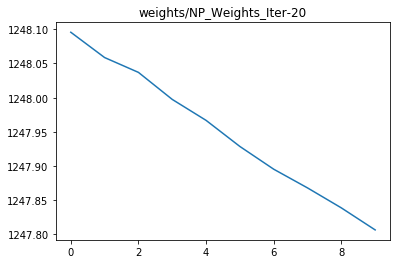

In [86]:
loss_list = []
# Number of iterations for training
num_iters = 20
# Number of iterations before we save our model
epochs_per_iter = 5
# Number of training examples pushed to the GPU per batch.
batch_size = 5

# Path to weights file
weights_path = 'weights/NP_Weights_Iter-' + str(num_iters)
cur_iter = 0

while cur_iter < num_iters:
    
    print('Iteration: ' + str(cur_iter))
    # Iterate over the training data in batches
    history = model.fit(x_data, y_data, batch_size=batch_size, epochs=epochs_per_iter, verbose=1, validation_split=0.0)
    loss_list += history.history['loss'] 
    cur_iter += 1
print('Training complete!')
model.save_weights(weights_path)

p1 = plt.plot(range(len(history_list)),history_list)
plt.title(weights_path)
plt.savefig(str(weights_path) + ".png")

In [47]:
# We take the first chunk of the training data itself for seed sequence.
seed_seq = x_data[0]
# Reshaping the sequence to feed to the RNN.
seed_seq = np.reshape(seed_seq, (1, seed_seq.shape[0], seed_seq.shape[1]))
# Generated song sequence is stored in output.
output = []
for it in range(max_seq_len):
    # Generates new value
    seedSeqNew = model.predict(seed_seq) 
    # Appends it to the output
    if it == 0:
        for i in range(seedSeqNew.shape[1]):
            output.append(seedSeqNew[0][i].copy())
    else:
        output.append(seedSeqNew[0][seedSeqNew.shape[1]-1].copy()) 
    # newSeq contains the generated sequence.
    newSeq = seedSeqNew[0][seedSeqNew.shape[1]-1]
    # Reshaping the new sequence for concatenation.
    newSeq = np.reshape(newSeq, (1, 1, newSeq.shape[0]))
    # Appending the new sequence to the old sequence.
    seed_seq = np.concatenate((seed_seq, newSeq[:,1:,:]), axis=1)

In [82]:
gen_song_nr = []
gen_song_nr = 0

In [83]:
# The path for the generated song
gen_song_nr += 1
song_path = 'generated_song_' +str(gen_song_nr) + ".wav"
# Reversing the conversions
time_blocks = fft_blocks_to_time_blocks(output)
song = convert_sample_blocks_to_np_audio(time_blocks)
write_np_as_wav(song, sample_frequency, song_path)

Text(0.5, 1.0, 'generated_song_1.wav')

Text(0.5, 0, 'Time (x 10^(-5)s)')

Text(0, 0.5, 'Amplitude')

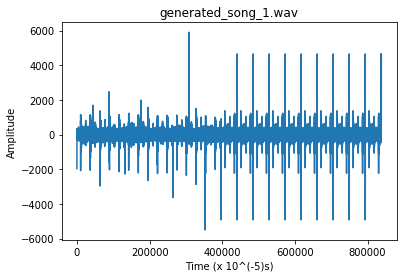

In [84]:
%matplotlib inline
bitrate, data = wav.read(song_path)
plt.plot(data)
plt.title(song_path)
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()
Audio(song_path)
None

In [85]:
!ls

Happy.mp3              create_dir.py          losslist.txt
Music_Generation.ipynb data_utils             nn_utils
README.md              datasets               notebooks
check_system_setup.py  gen_utils              requirements.txt
config                 generate.py            train.py
convert_directory.py   generated_song_1.wav   weights


In [80]:
!rm generated_song_3.wav